# Understanding the problem

We're trying to **recover or infer a periodic signal** that is **corrupted by noise**. We have, <br>
<center> $ y_i = f(t_i) + \epsilon_i $ </center>

where,
* $y_i$ is the observed signal at time $t_i$
* $f(t_i)$ is the **true periodic signal**
* $\epsilon_i \sim \mathcal{N}(0, \sigma ^2)$ is the additive **Gaussian noise**

`Goal`: To infer the **posterior distribution** over parameters that define $f(t)$ given the noisy observations $y(t)$

## 1. Simple model

We start with the simplest parametric periodic function: <br>
<center> $ f(t) = A.\sin (2 \pi \omega t + \phi) $ </center>

where,
* $A$ is the **Amplitude** (height) of oscillation
* $\omega$ is the **Frequency** of oscillation
* $\phi$ is the **Phase** (horizontal shift) of oscillation

Assuming Gaussian noise, the **likelihood** of the observed data $\{y_i\}_{i=1}^{n}$ is, <br>
<center> $ \mathcal{L}(A, \omega, \phi, \sigma^2 | y) = \prod_{i=1}^{n} f(y_i | A, \omega, \phi, \sigma^2 ) = \prod_{i=1}^{n} f_{\mathcal{N}}(y_i | A.\sin (2 \pi \omega t + \phi), \sigma^2 ) $ </center>

The **negative log-likelihood** becomes, <br>
<center> $ - \log f(y | \theta) = \frac{n}{2}\log(2\pi\sigma^2) + \frac{1}{2\sigma^2} \sum_{i=1}^{n}(y_i - A.\sin (2 \pi \omega t + \phi))^2 $ </center>

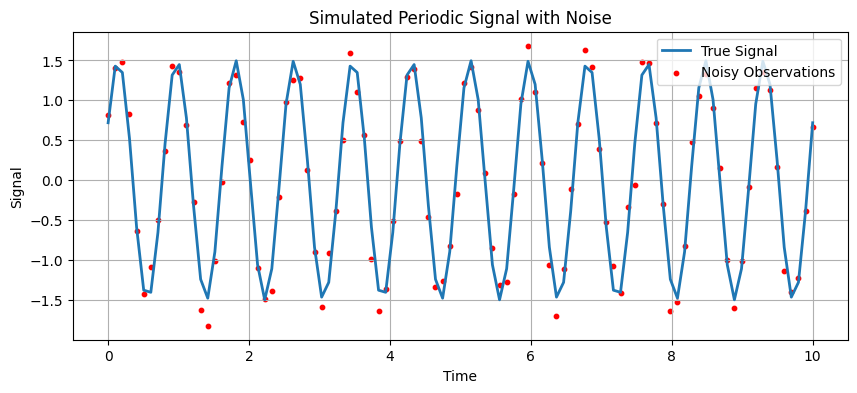

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate time points
t = np.linspace(0, 10, 100)

# True signal parameters
A_true = 1.5
omega_true = 1.2
phi_true = 0.5
sigma_true = 0.2

# Generate true signal and noisy observations
f_true = A_true * np.sin(2 * np.pi * omega_true * t + phi_true)
y_obs = f_true + np.random.normal(0, sigma_true, size=len(t))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t, f_true, label='True Signal', linewidth=2)
plt.scatter(t, y_obs, color='r', s=10, label='Noisy Observations')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("Simulated Periodic Signal with Noise")
plt.grid(True)
plt.show()

In [2]:
import pymc as pm
import arviz as az

with pm.Model() as periodic_model:
    # Priors
    A = pm.Normal('A', mu=0, sigma=5)
    omega = pm.Uniform('omega', lower=0, upper=2)
    phi = pm.Uniform('phi', lower=0, upper=2 * np.pi)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Mean function (sinusoid)
    mu = A * pm.math.sin(2 * np.pi * omega * t + phi)

    # Likelihood
    Y = pm.Normal('Y', mu=mu, sigma=sigma, observed=y_obs)

    # Sampling from the posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, omega, phi, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 536 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


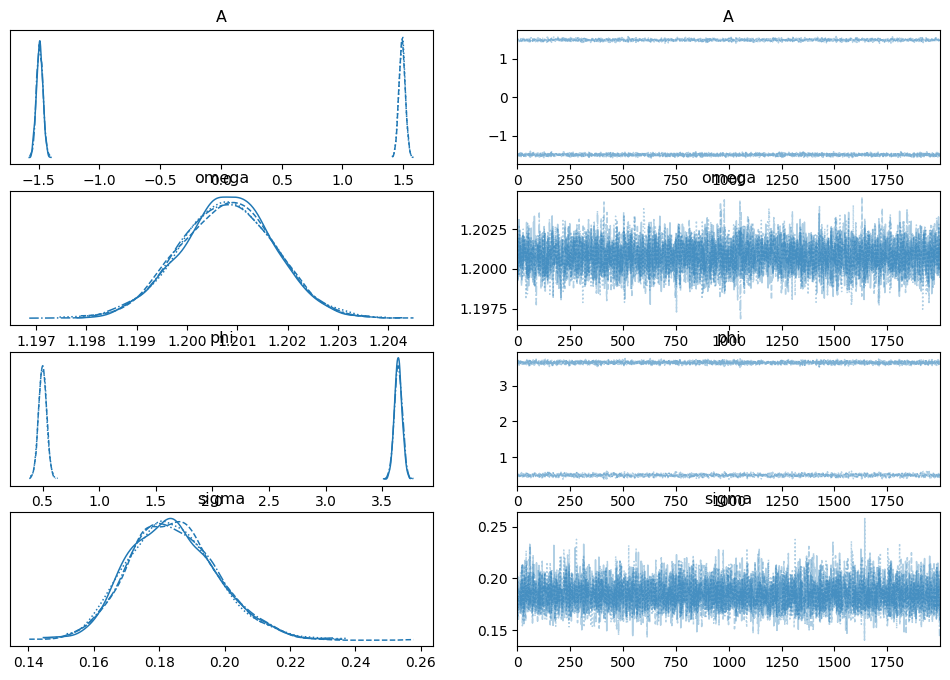

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.001,1.491,-1.536,1.534,0.744,0.0,6.0,137.0,1.73
omega,1.201,0.001,1.199,1.203,0.000,0.0,4974.0,4649.0,1.00
phi,2.072,1.571,0.444,3.700,0.784,0.0,6.0,118.0,1.73
sigma,0.184,0.014,0.160,0.213,0.000,0.0,6108.0,5079.0,1.00


In [3]:
# Traceplot
az.plot_trace(trace)
plt.show()

# Posterior summary
az.summary(trace, hdi_prob=0.95)


Sampling: [Y]


Output()

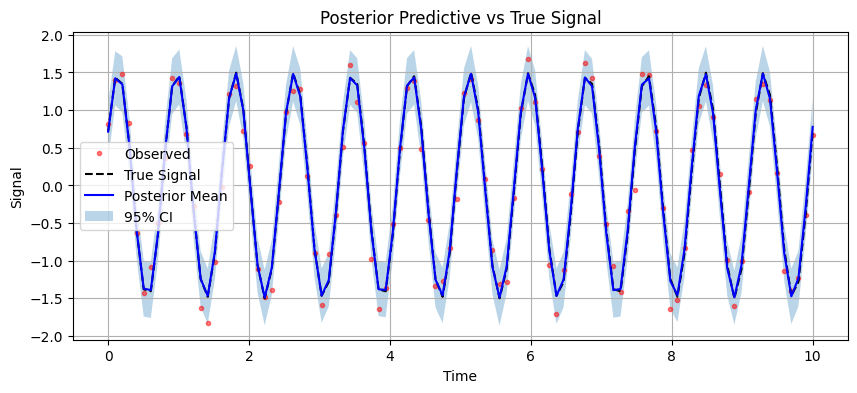

In [6]:
with periodic_model:
    posterior_pred = pm.sample_posterior_predictive(trace, var_names=["Y"])

y_pred_samples = posterior_pred.posterior_predictive['Y'].values
y_pred_samples = y_pred_samples.reshape(-1, y_pred_samples.shape[-1])

plt.figure(figsize=(10, 4))
plt.plot(t, y_obs, 'r.', alpha=0.5, label="Observed")
plt.plot(t, f_true, 'k--', label="True Signal")
plt.plot(t, y_pred_samples.mean(axis=0), 'b', label="Posterior Mean")
plt.fill_between(t,
                 np.percentile(y_pred_samples, 2.5, axis=0),
                 np.percentile(y_pred_samples, 97.5, axis=0),
                 alpha=0.3, label="95% CI")
plt.legend()
plt.title("Posterior Predictive vs True Signal")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.grid(True)
plt.show()


## 2. Multi-Harmonic model

Next up, we start with a **Multi-harmonic periodic function** with `K = 2`<br>
<center> $ f(t) = A_1 \sin(2\pi \omega t + \phi_1) + A_2 \sin(4 \pi \omega t + \phi_2) $ </center>

where, 
* $A_i$ (for $i=1,2$) is the **Amplitude** (height) of oscillation
* $\omega$ is the **Frequency** of oscillation
* $\phi_i$ (for $i=1,2$) is the **Phase** (horizontal shift) of oscillation

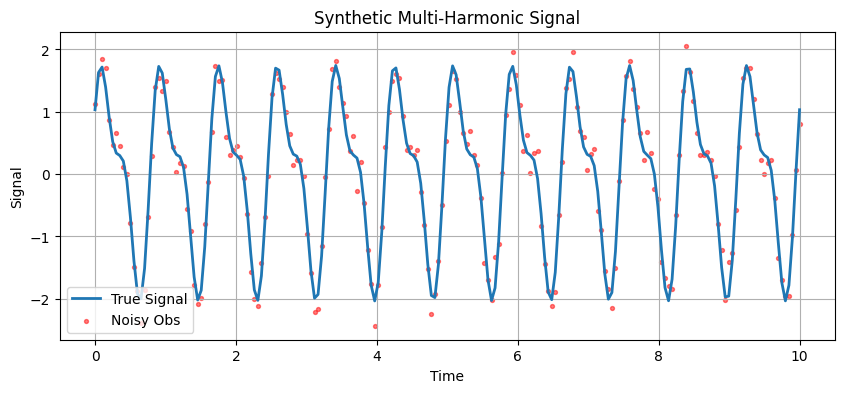

In [10]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Time
t = np.linspace(0, 10, 200)

# True parameters
A1_true = 1.5
A2_true = 0.7
omega_true = 1.2
phi1_true = 0.3
phi2_true = 1.0
sigma_true = 0.2

# True signal
f_true = (
    A1_true * np.sin(2 * np.pi * omega_true * t + phi1_true)
    + A2_true * np.sin(4 * np.pi * omega_true * t + phi2_true)
)

# Noisy observations
y_obs = f_true + np.random.normal(0, sigma_true, size=len(t))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t, f_true, label='True Signal', linewidth=2)
plt.scatter(t, y_obs, s=8, color='r', alpha=0.5, label='Noisy Obs')
plt.legend()
plt.title("Synthetic Multi-Harmonic Signal")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.grid(True)
plt.show()


In [11]:
import pymc as pm

with pm.Model() as harmonic_model:
    # Priors
    A1 = pm.Normal("A1", mu=0, sigma=5)
    A2 = pm.Normal("A2", mu=0, sigma=5)
    omega = pm.Uniform("omega", lower=0.5, upper=2.0)
    phi1 = pm.Uniform("phi1", lower=0, upper=2 * np.pi)
    phi2 = pm.Uniform("phi2", lower=0, upper=2 * np.pi)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Mean function
    mu = (
        A1 * pm.math.sin(2 * np.pi * omega * t + phi1)
        + A2 * pm.math.sin(4 * np.pi * omega * t + phi2)
    )

    # Likelihood
    Y = pm.Normal("Y", mu=mu, sigma=sigma, observed=y_obs)

    # Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A1, A2, omega, phi1, phi2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1206 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


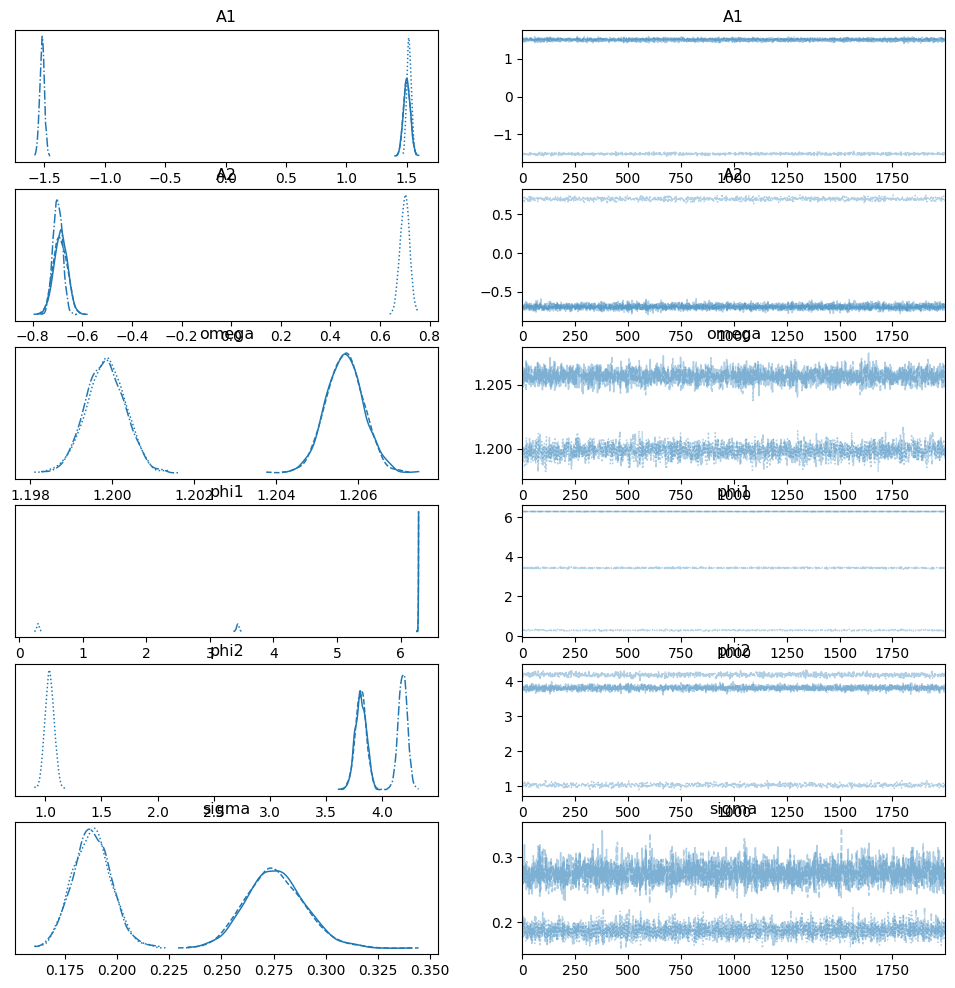

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A1,0.750,1.311,-1.544,1.554,0.654,0.378,7.0,27.0,1.59
A2,-0.344,0.604,-0.738,0.724,0.301,0.174,7.0,30.0,1.55
omega,1.203,0.003,1.199,1.206,0.001,0.000,6.0,120.0,1.73
phi1,4.075,2.470,0.281,6.283,1.232,0.510,5.0,28.0,2.10
phi2,3.210,1.263,0.986,4.232,0.630,0.359,5.0,29.0,2.41
sigma,0.232,0.046,0.170,0.296,0.022,0.000,6.0,107.0,1.73


In [12]:
import arviz as az

az.plot_trace(trace)
plt.show()

az.summary(trace, hdi_prob = 0.95)

Sampling: [Y]


Output()

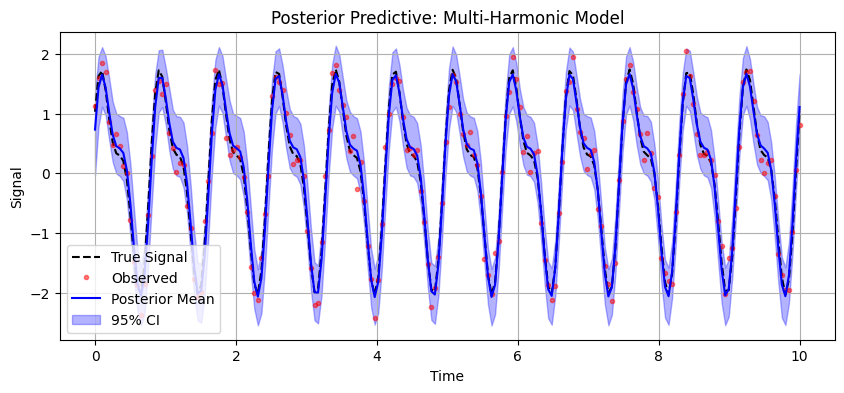

In [13]:
with harmonic_model:
    posterior_pred = pm.sample_posterior_predictive(trace, var_names=["Y"])

# Extract & flatten predictions
y_pred_samples = posterior_pred.posterior_predictive['Y'].values
y_pred_samples = y_pred_samples.reshape(-1, y_pred_samples.shape[-1])

# Plot prediction
plt.figure(figsize=(10, 4))
plt.plot(t, f_true, 'k--', label='True Signal')
plt.plot(t, y_obs, 'r.', label='Observed', alpha=0.5)
plt.plot(t, y_pred_samples.mean(axis=0), 'b', label='Posterior Mean')
plt.fill_between(t,
                 np.percentile(y_pred_samples, 2.5, axis=0),
                 np.percentile(y_pred_samples, 97.5, axis=0),
                 color='b', alpha=0.3, label='95% CI')
plt.legend()
plt.title("Posterior Predictive: Multi-Harmonic Model")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.grid(True)
plt.show()


## 3. Application in Kepler data

In [10]:
import numpy as np
import matplotlib.pyplot as plt

flux1 = np.genfromtxt("Kepler1.dat", dtype=np.float32, missing_values="NA", filling_values=np.nan)
flux2 = np.genfromtxt("Kepler2.dat", dtype=np.float32, missing_values="NA", filling_values=np.nan)

flux1 = flux1[~np.isnan(flux1)]
flux2 = flux2[~np.isnan(flux2)]

# Create artificial time grid assuming 30-min cadence
# (Kepler long cadence ≈ 29.4 minutes)
t1 = np.arange(len(flux1)) * 0.0204  # in days (~29.4 min)
t2 = np.arange(len(flux2)) * 0.0204

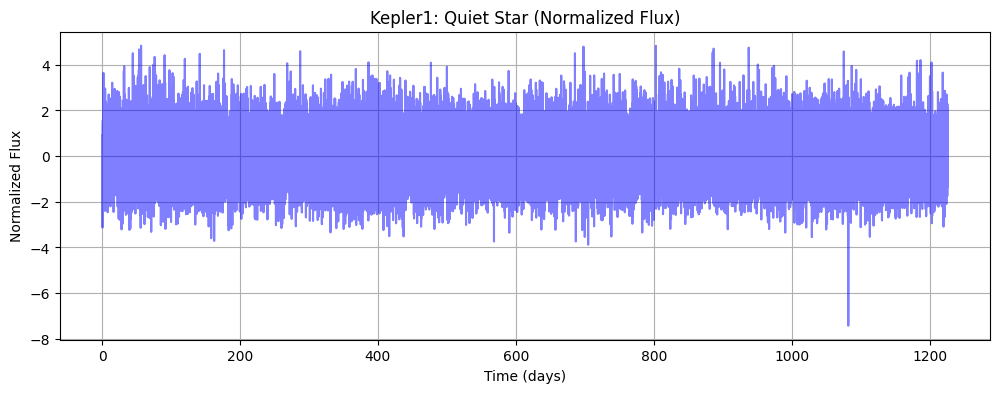

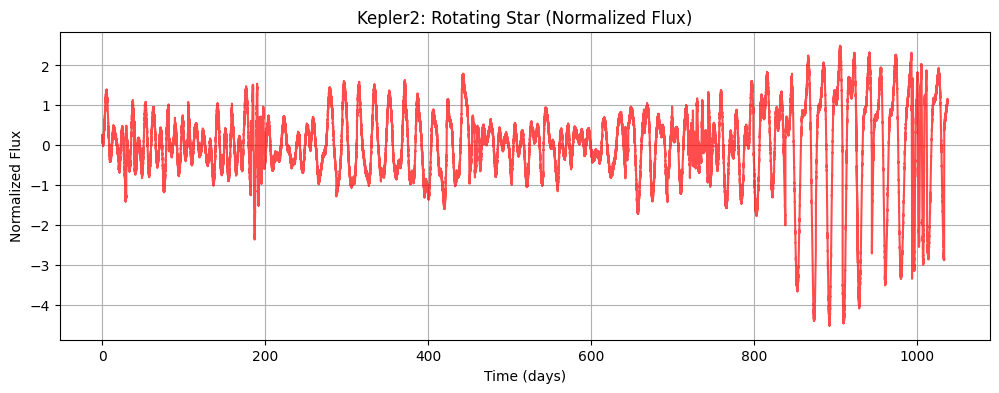

In [14]:
# Normalize
flux1_norm = (flux1 - np.mean(flux1)) / np.std(flux1)
flux2_norm = (flux2 - np.mean(flux2)) / np.std(flux2)

plt.figure(figsize=(12, 4))
plt.plot(t1, flux1_norm, 'b-', alpha=0.5)
plt.title("Kepler1: Quiet Star (Normalized Flux)")
plt.xlabel("Time (days)")
plt.ylabel("Normalized Flux")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(t2, flux2_norm, 'r-', alpha=0.7)
plt.title("Kepler2: Rotating Star (Normalized Flux)")
plt.xlabel("Time (days)")
plt.ylabel("Normalized Flux")
plt.grid(True)
plt.show()


### 3.1. Simple Harmonic Model for Kepler 1 (Quiet star)

We implement the **Simple Harmonic Model** here:<br>
<center> $ f(t) = A.\sin (2 \pi \omega t + \phi) $ </center>

In [16]:
import pymc as pm

# Subsample for speed
subset1 = 30
t1_sub = t1[::subset1]
y1_sub = flux1_norm[::subset1]

with pm.Model() as kepler1_model:
    A = pm.Normal("A", mu=0, sigma=2)
    omega = pm.Uniform("omega", lower=0.05, upper=2.0)
    phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    mu = A * pm.math.sin(2 * np.pi * omega * t1_sub + phi)
    Y = pm.Normal("Y", mu=mu, sigma=sigma, observed=y1_sub)

    trace1 = pm.sample(10, tune=10, chains=2, cores=1)


Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [A, omega, phi, sigma]


Output()

C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\scalar\basic.py:1548: 
RuntimeWarning: overflow encountered in cast
  return np.greater_equal(x, y)

C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:710: 
RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

C:\Users\Shyam Banerjee\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:86: 
RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

Sampling 2 chains for 10 tune and 10 draw iterations (20 + 20 draws total) took 73 seconds.
The number of samples is too small to check convergence reliably.


In [24]:
with kepler1_model:
    posterior_pred = pm.sample_posterior_predictive(trace1, var_names=["Y"])

y_pred_samples = posterior_pred.posterior_predictive['Y'].values
y_pred_samples = y_pred_samples.reshape(-1, y_pred_samples.shape[-1])

print(t1_sub.shape)
print(y_pred_samples.shape)

Sampling: [Y]


Output()

(2003,)
(20, 2003)


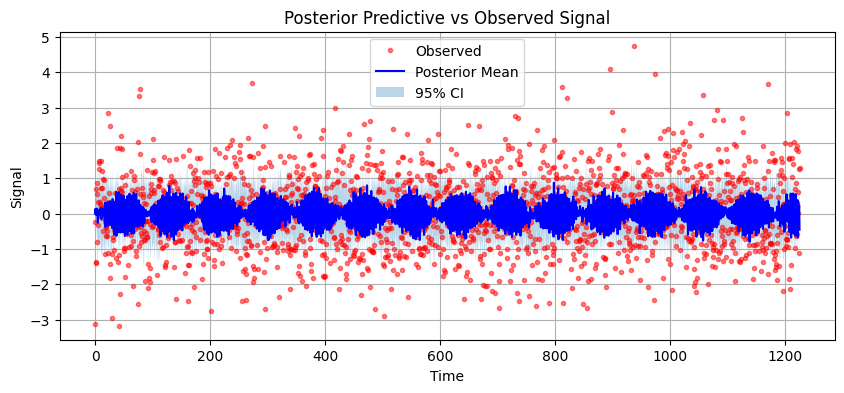

In [28]:


plt.figure(figsize=(10, 4))
plt.plot(t1_sub, y1_sub, 'r.', alpha=0.5, label="Observed")
plt.plot(t1_sub, y_pred_samples.mean(axis=0), 'b', label="Posterior Mean")
plt.fill_between(t1_sub,
                 np.percentile(y_pred_samples, 2.5, axis=0),
                 np.percentile(y_pred_samples, 97.5, axis=0),
                 alpha=0.3, label="95% CI")
plt.legend()
plt.title("Posterior Predictive vs Observed Signal")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.grid(True)
plt.show()

### 3.2. Multi-Harmonic Model for Kepler 2 (Rotating star)

We implement the **Multi-harmonic (K = 2) periodic model** here`<br>
<center> $ f(t) = A_1 \sin(2\pi \omega t + \phi_1) + A_2 \sin(4 \pi \omega t + \phi_2) $ </center>

In [19]:
# Subsample
subset2 = 30
t2_sub = t2[::subset2]
y2_sub = flux2_norm[::subset2]

with pm.Model() as kepler2_model:
    A1 = pm.Normal("A1", mu=0, sigma=2)
    A2 = pm.Normal("A2", mu=0, sigma=2)
    omega = pm.Uniform("omega", lower=0.05, upper=2.0)
    phi1 = pm.Uniform("phi1", lower=0, upper=2*np.pi)
    phi2 = pm.Uniform("phi2", lower=0, upper=2*np.pi)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    mu = (A1 * pm.math.sin(2 * np.pi * omega * t2_sub + phi1) +
          A2 * pm.math.sin(4 * np.pi * omega * t2_sub + phi2))

    Y = pm.Normal("Y", mu=mu, sigma=sigma, observed=y2_sub)
    trace2 = pm.sample(10, tune=10, chains=2, cores=1)


Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [A1, A2, omega, phi1, phi2, sigma]


Output()

Sampling 2 chains for 10 tune and 10 draw iterations (20 + 20 draws total) took 149 seconds.
The number of samples is too small to check convergence reliably.


In [29]:
with kepler2_model:
    posterior_pred = pm.sample_posterior_predictive(trace2, var_names=["Y"])

y_pred_samples = posterior_pred.posterior_predictive['Y'].values
y_pred_samples = y_pred_samples.reshape(-1, y_pred_samples.shape[-1])

print(t2_sub.shape)
print(y_pred_samples.shape)

Sampling: [Y]


Output()

(1695,)
(20, 1695)


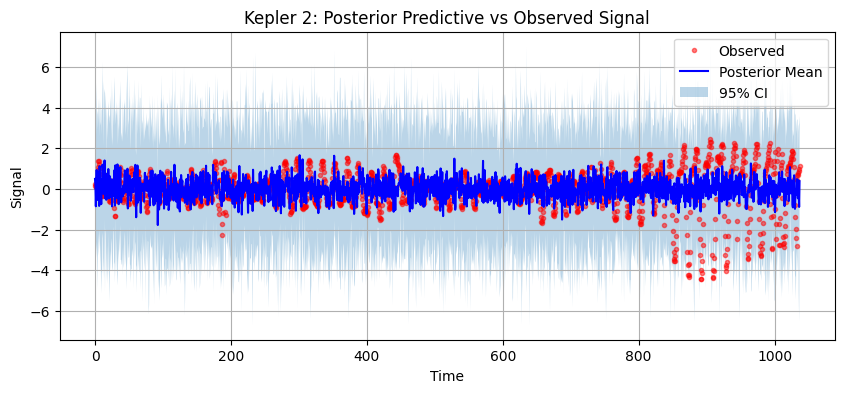

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(t2_sub, y2_sub, 'r.', alpha=0.5, label="Observed")
plt.plot(t2_sub, y_pred_samples.mean(axis=0), 'b', label="Posterior Mean")
plt.fill_between(t2_sub,
                 np.percentile(y_pred_samples, 2.5, axis=0),
                 np.percentile(y_pred_samples, 97.5, axis=0),
                 alpha=0.3, label="95% CI")
plt.legend()
plt.title("Kepler 2: Posterior Predictive vs Observed Signal")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.grid(True)
plt.show()